<a href="https://colab.research.google.com/github/w-oke/covid_reproduction/blob/main/covid_owid_2_analysis_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data loaded in this Notebook is based on the output of: covid_owid_1_preparation.ipynb, which can be accessed from:
https://github.com/w-oke/covid_reproduction.

In [2]:
import urllib.request
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from tensorflow import keras

In [2]:
df_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_df.parquet'
df1 = pd.read_parquet(df_link)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14671 entries, 0 to 14670
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             14671 non-null  object        
 1   location                             14671 non-null  object        
 2   date                                 14671 non-null  datetime64[ns]
 3   reproduction_rate                    14671 non-null  float64       
 4   new_tests_smoothed_per_thousand      14671 non-null  float64       
 5   people_vaccinated_per_hundred        14671 non-null  float64       
 6   people_fully_vaccinated_per_hundred  14671 non-null  float64       
 7   total_boosters_per_hundred           14671 non-null  float64       
 8   stringency_index                     14671 non-null  float64       
 9   population_density                   14671 non-null  float64       
 10  median_age

In [3]:
df1.describe()

,reproduction_rate,new_tests_smoothed_per_thousand,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Lambda,Mu,Omicron,non_who,date_diff
count,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000,14671.000000
mean,0.981247,0.026298,0.148454,0.114431,0.021224,0.555056,0.015554,0.473407,0.153223,0.134494,0.681668,0.208556,0.587462,0.590860,13.710374,3.134258,27.818503,0.159002,0.454525,2.199476,0.207535,0.131778,0.503047,0.498972,0.252521,50.930009,0.510624
std,0.309696,0.059445,0.226695,0.205292,0.066018,0.182632,0.078171,0.280223,0.167145,0.241245,0.314402,0.172136,0.230449,0.272662,24.165125,10.122518,40.730910,1.338521,2.929623,7.994121,1.754144,1.158653,3.291833,3.367829,2.399186,44.403557,0.289618
min,-0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010000,0.000000
25%,0.830000,0.002815,0.000000,0.000000,0.000000,0.433105,0.001848,0.208459,0.032584,0.006452,0.443836,0.087591,0.413206,0.355240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.515000,0.259259
50%,1.000000,0.011031,0.012334,0.003801,0.000000,0.555600,0.004167,0.468278,0.096149,0.012903,0.858901,0.167664,0.633403,0.632327,0.239675,0.018182,0.042349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.950000,0.518519
75%,1.150000,0.028369,0.241835,0.130882,0.002901,0.694400,0.010465,0.740181,0.224609,0.127742,0.906227,0.270073,0.755602,0.813499,17.745625,2.317532,73.398196,0.013782,0.026742,1.366321,0.010353,0.002574,0.294365,0.156952,0.000000,99.999861,0.765432
max,4.190000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,60.190000,82.410000,82.830000,100.000000,100.000000,1.000000


In [3]:
# import the dictionary var with lists of features:
#var_link = 'https://github.com/w-oke/covid_reproduction/raw/main/covid_owid_var_dictionary.pkl'
a_file = "covid_owid_var_dictionary.pkl"

with open(a_file, 'rb') as f:
        var = pickle.load(f)

print('The keys of the \'var\' dict are: ', var.keys())
print()
var

The keys of the 'var' dict are:  dict_keys(['y', 'meta', 'number', 'variants', 'vaccine', 'scale', 'imputer_no_date', 'imputer_date'])



{'imputer_date': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  'total_boosters_per_hundred',
  'gdp_per_capita',
  'hospital_beds_per_thousand',
  'stringency_index',
  'date_diff'],
 'imputer_no_date': ['population_density',
  'median_age',
  'gdp_per_capita',
  'extreme_poverty',
  'handwashing_facilities',
  'hospital_beds_per_thousand',
  'life_expectancy',
  'human_development_index'],
 'meta': ['date', 'iso_code', 'location'],
 'number': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  'total_boosters_per_hundred',
  'stringency_index',
  'population_density',
  'median_age',
  'human_development_index',
  'gdp_per_capita',
  'extreme_poverty',
  'handwashing_facilities',
  'hospital_beds_per_thousand',
  'life_expectancy'],
 'scale': ['new_tests_smoothed_per_thousand',
  'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred',
  't

In [5]:
# allocate 20% of the data set to testing
X_train, X_test, y_train, y_test = train_test_split(
                        df1[var['number']+var['variants']], df1[var['y']], 
                        test_size=0.2, random_state=1)

# allocate 25% of the remaining examples (20% of the dataset) to validation
X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
# create a DNN model with 3 fully connected layers with 64 units each
model = keras.Sequential([
                          keras.layers.BatchNormalization(),
                          keras.layers.Dense(units=64, activation='relu'),
                          keras.layers.Dense(units=64, activation='relu'),
                          keras.layers.Dense(units=64, activation='relu'),
                          keras.layers.Dense(units=1)]) # linear output layer for regression
model.compile(optimizer='adam',
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()])

The following hyperparameter values were evaluated, which all resulted in test data RMSE results in the range of 0.24 to 0.29:
* number of Dense layers: 1, 2, 3
* number of units per layer: 64, 128
* optimizer 'adam' and 'sgd'
* keras.layers.Dropout(0.2) between each layer
* keras.layers.BatchNormalization() between each layer
* training batch size of 16 & 32
* keras.callbacks.ReduceLROnPlateau()

In [7]:
early_stopping = keras.callbacks.EarlyStopping(patience=20,
                                               restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5)
history = model.fit(X_train, y_train,
    batch_size = 16, 	# number of examples in each batch before step
    epochs = 500, 		# will cycle through all trg data 500 times unless:
    callbacks=[early_stopping, lr_schedule], # put callbacks in a list; use lg epochs value
    validation_data = (X_val, y_val)) # to monitor performance

Epoch 1/500
551/551 [==============================] - 2s 3ms/step - loss: 0.1175 - root_mean_squared_error: 0.3428 - val_loss: 0.2192 - val_root_mean_squared_error: 0.4682 - lr: 0.0010
Epoch 2/500
551/551 [==============================] - 1s 3ms/step - loss: 0.0918 - root_mean_squared_error: 0.3030 - val_loss: 0.1255 - val_root_mean_squared_error: 0.3543 - lr: 0.0010
Epoch 3/500
551/551 [==============================] - 1s 2ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939 - val_loss: 0.1043 - val_root_mean_squared_error: 0.3230 - lr: 0.0010
Epoch 4/500
551/551 [==============================] - 1s 2ms/step - loss: 0.0836 - root_mean_squared_error: 0.2891 - val_loss: 0.1087 - val_root_mean_squared_error: 0.3297 - lr: 0.0010
Epoch 5/500
551/551 [==============================] - 1s 2ms/step - loss: 0.0817 - root_mean_squared_error: 0.2858 - val_loss: 0.0930 - val_root_mean_squared_error: 0.3049 - lr: 0.0010
Epoch 6/500
551/551 [==============================] - 1s 3ms/step - l

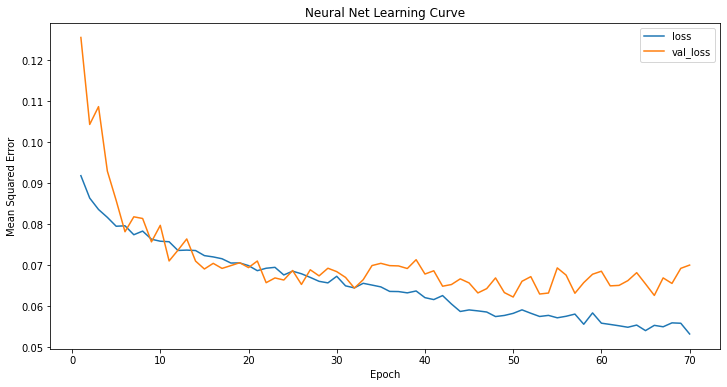

In [25]:
history_df = pd.DataFrame(history.history) # convert the trg history to a DF
fig, ax = plt.subplots(figsize=(12,6))
history_df.loc[1:, ['loss', 'val_loss']].plot(ax=ax)
ax.set(title='Neural Net Learning Curve', xlabel='Epoch', 
       ylabel='Mean Squared Error');

We can see that the model starts to overtrain the training data set after 30-40 epochs.

In [26]:
# Calculate the Standard Deviation of y
y_sd = float(np.sqrt(df1[var['y']].var()))
print("The Standard Deviation of the Reproduction Rate (the dependent variable) is {:.4f}".format(y_sd))

The Standard Deviation of the Reproduction Rate (the dependent variable) is 0.3097


In [13]:
rmse = model.evaluate(X_test, y_test)[1]

92/92 [==============================] - 0s 1ms/step - loss: 0.0610 - root_mean_squared_error: 0.2470


In [14]:
print('Only {:.1f}% of the variability in the Reproduction Rate is explained by this model'.format(100*(y_sd-rmse)/y_sd))

Only 20.3% of the variability in the Reproduction Rate is explained by this model
